In [1]:
# need this to actually open the big tar file:
# https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-in-jupyter-notebook-when-viewing-image

import pandas as pd
import numpy as np
import gzip
import tarfile
from io import StringIO
import re
import math
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

#pretty
class printer(str):
    def __repr__(self):
       return self

class idisplay:
    def __init__(self,str):
        self.myobject = display.display(printer(str), display_id=True)
        
    def update(self,str):
        return self.myobject.update(printer(str))

In [2]:
# copy-pasted with np fixes and index removal for metadata
# https://gitlab.com/-/snippets/1838910

metadata_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

metadata_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }


# Data specs #

data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})


# Reading functions #

def read_station_metadata(filename="ghcnd-stations.txt"):
    """Reads in station metadata

    :filename: ghcnd station metadata file.
    :returns: station metadata as a pandas Dataframe

    """
    df = pd.read_fwf(filename, colspecs = metadata_col_specs, names=metadata_names, dtype=metadata_dtype)

    return df


def read_ghcn_data_file(filename="ghcnd_all/ACW00011604.dly",
                        variables=None, include_flags=False,
                        dropna='all'):
    """Reads in all data from a GHCN .dly data file

    :param filename: path to file
    :param variables: list of variables to include in output dataframe
        e.g. ['TMAX', 'TMIN', 'PRCP']
    :param include_flags: Whether to include data quality flags in the final output
    :returns: Pandas dataframe
    """

    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    df = df.stack(level='DAY').unstack(level='ELEMENT').reset_index(level=("ID",))

    if dropna:
        df.replace(-9999.0, np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)

    # replace the entire index with the date.
    # This loses the station ID index column!
    # This will usuall fail if dropna=False, since months with <31 days
    # still have day=31 columns
    # df['DATE'] = pd.to_datetime(
    #     df.index.get_level_values('YEAR') * 10000 +
    #     df.index.get_level_values('MONTH') * 100 +
    #     df.index.get_level_values('DAY'),
    #     format='%Y%m%d')

    return df


In [3]:
tar = tarfile.open("data/ghcnd_all.tar.gz","r:gz")
allmembers = tar.getmembers()

In [5]:
# get valid stations; no need to do this one without editing the parameters!

lat_min = 28.0
lat_max = 49.0
long_min = -97.0
long_max = -68.0
valid_stations=[]
station_data = read_station_metadata("Data/ghcnd-stations.txt")
console = idisplay("Starting...")
valid_count = 0
i = 1
while i<len(allmembers)-1:
    # print(tar.extractfile(allmembers[i]).read().decode('utf-8'))
    addend = read_ghcn_data_file(StringIO(tar.extractfile(allmembers[i]).read().decode('utf-8')))
    station = re.search("(?<=\/)(.+)(?=\.)",allmembers[i].name).group(0)
    my_station_data = station_data.loc[station_data["ID"]==station].iloc[0]
    lat = math.floor(1.0*my_station_data[["LATITUDE"]].iloc[0])/1.0
    long = math.floor(1.0*my_station_data[["LONGITUDE"]].iloc[0])/1.0
    if (not (lat<lat_min or lat >=lat_max or long < long_min or long >= long_max)):
        valid_stations.append(i)
        valid_count+=1
    console.update("Scraped "+str(i)+", found "+str(valid_count))
    i+=1
f = open("Data/valid_stations.txt", "a")
f.write(str(valid_stations))
f.close()
console.update("Scraped "+str(i-1)+", found "+str(valid_count)+"; done!")

Scraped 457, found 0

KeyboardInterrupt: 

In [7]:
# compile station data

weather_by_grid = pd.DataFrame()
station_data = read_station_metadata("Data/ghcnd-stations.txt")
valid_stations = list(map(int,list(open('Data/valid_stations.txt', 'r').read()[1:-1].split(", "))))
get_count = -1
year_mod = 5 # only consider years multiples of year_mod, for speed

console = idisplay("You have "+str(len(valid_stations))+" stations! You're about to scrape the first "
                   +str(min(len(allmembers)-1,get_count))+".")

win_count = 0
# for i in range(min(get_count,len(valid_stations))):
for i in range(0,41833):
    addend = read_ghcn_data_file(StringIO(tar.extractfile(allmembers[valid_stations[i]]).read().decode('utf-8')))
    station = re.search("(?<=\/)(.+)(?=\.)",allmembers[valid_stations[i]].name).group(0)
    my_station_data = station_data.loc[station_data["ID"]==station].iloc[0]
    lat = math.floor(1.0*my_station_data[["LATITUDE"]].iloc[0])/1.0
    long = math.floor(1.0*my_station_data[["LONGITUDE"]].iloc[0])/1.0
    addend[["LATITUDE","LONGITUDE"]]=[lat,long]
    addend = addend.set_index(["LATITUDE","LONGITUDE"],append=True)
    # print(type(np.array(addend.columns)& np.array(["TMAX"])))
    # print(np.array(addend.columns)&["TMAX"])
    # print(np.array(addend.columns) & np.array(addend.columns))
    addend = addend[addend.columns.intersection(["PRCP",
                                                "SNOW",
                                                "TMAX",
                                                "TMIN"])]
    for j in addend.columns:
        addend[j+'_CNT']=addend[j].apply(lambda a : int((not isinstance(a,float)) or (not math.isnan(a))))
    # addend = addend.loc[addend.index.get_level_values("YEAR")%year_mod==0]
    addend = addend.loc[addend.index.get_level_values("YEAR")>2016]
    # addend = addend.loc[addend.index.get_level_values("MONTH")==7]
    # addend = addend.loc[addend.index.get_level_values("DAY")==4]
    if win_count == 0:
        weather_by_grid = addend
    else:
        weather_by_grid = weather_by_grid.add(addend,fill_value = 0)
    win_count+=1
    console.update(str(valid_stations[i])+" "+str(win_count)+" "+str(weather_by_grid.size))
    if win_count==get_count:
        break
console.update("You've scraped "+str(win_count)+" stations; done!")

You've scraped 41833 stations; done!

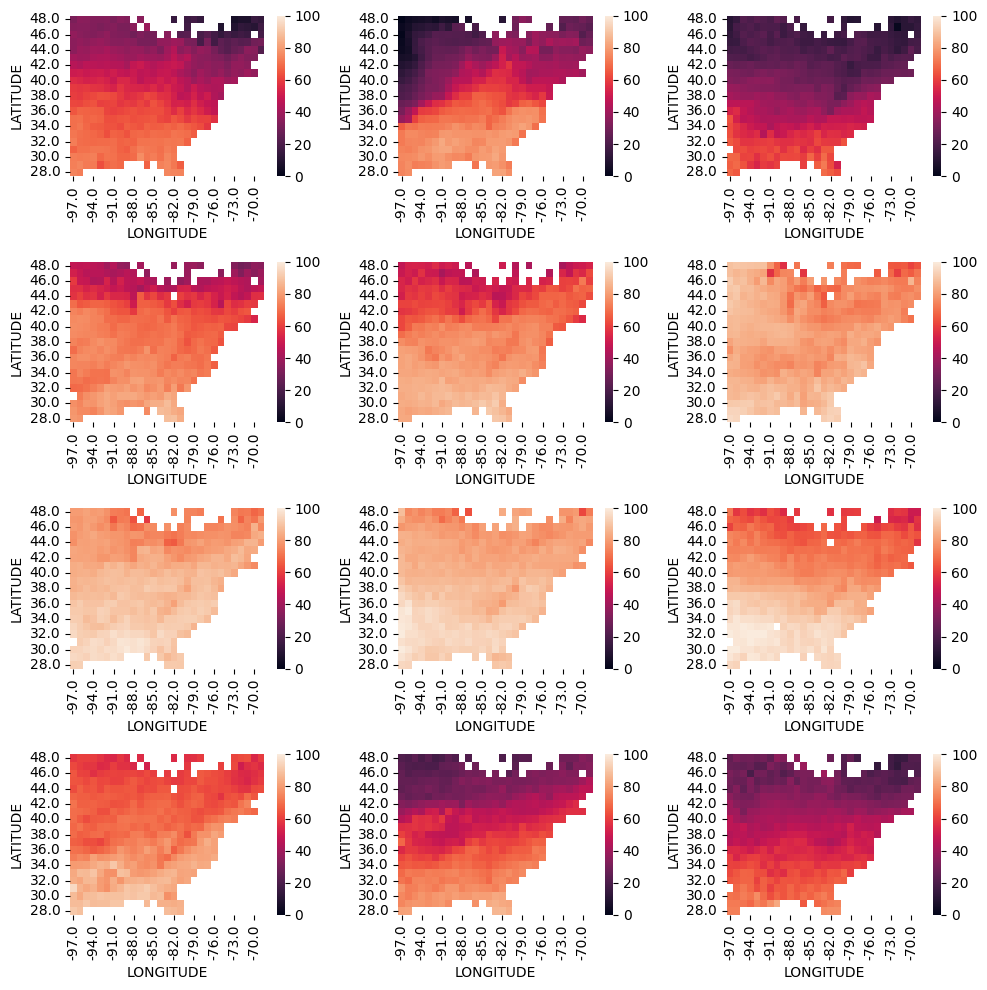

In [8]:
pd.set_option('display.min_rows',100)
pd.set_option('display.max_rows',100)

fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(10,10))

for i in range(1,13):
    wg = weather_by_grid
    
    # print(wg.index)
    wg = wg[wg.index.isin([2019], level="YEAR")]
    wg = wg[wg.index.isin([i], level="MONTH")]
    wg=wg[wg.index.isin([7], level="DAY")]
    wg = wg.reset_index(level="LATITUDE").reset_index(level="LONGITUDE")
    # print(wg[["TMAX","TMAX_CNT","LATITUDE","LONGITUDE"]])
    # wg = wg.pivot("LATITUDE","LONGITUDE","TMAX")
    
    # print(wg)
    def average(row):
        if row["TMAX_CNT"]==0: return float("nan")
        else:
            celsius = .1*(float(row["TMAX"])/float(row["TMAX_CNT"]))
            return (celsius*9/5)+32
            
    wg["TMAX_AVG"]=wg.apply(average, axis=1)
    
    wg = pd.pivot_table(wg,values='TMAX_AVG',
                        index="LATITUDE",
                        columns="LONGITUDE")
    
    # wg[wg.index.get_level_values('YEAR').isin(['1975'])]
    # print(weather_by_grid)
    sns.heatmap(wg,ax=axes[math.floor((i-1)/3)][(i-1)%3],vmin=0,vmax=100).invert_yaxis()
fig.tight_layout()
# print(weather_by_grid)
# print(weather_by_grid.size)
# print(weather_by_grid.loc[weather_by_grid
#       .index.get_level_values('YEAR') ==1975]
#       [["TMAX","TMAX_CNT"]].dropna()
#      .sort_values(by=['TMAX_CNT']))
# print(df[["NAME","TMAX"]].dropna(subset="TMAX").sort_values("TMAX"))

In [9]:
weather_by_grid.to_csv(r'data/weather_seven.txt')
